In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import ipywidgets as widgets
import scipy.integrate as integrate

from ipywidgets import interact
from matplotlib import animation

# if you're on the dark side
plt.style.use('dark_background')

# Inhomogeneous Semiconductors (Chapter 7)

The notebook at hand will lead you through some important concepts about an inhomogeneous semiconductor. The model look at take here is simply the conjunction of two homogeneous semiconductors with a variable doping concentration.


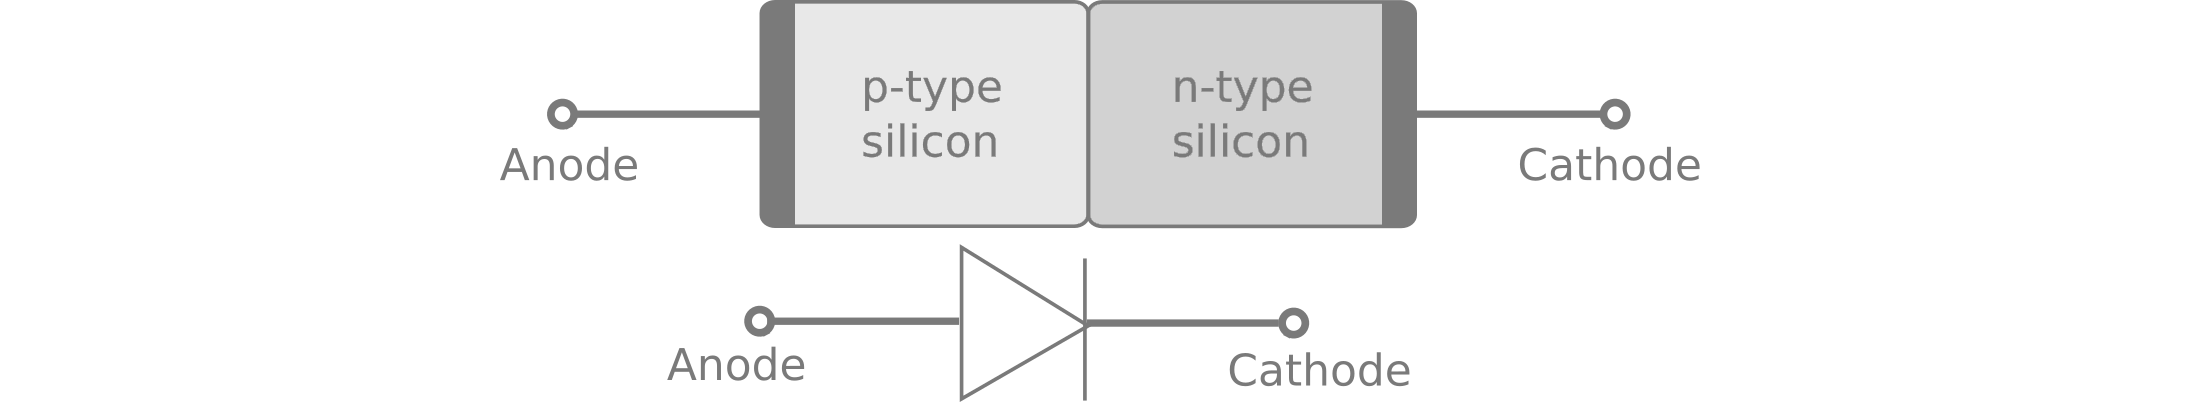

In [30]:
# define constants
kB = 1.380649e-23 # J/K
hbar = 6.626e-34 / (2*np.pi) # J*s
e = 1.60217733e-19 # C
m0 = 9.109383e-31 # kg
T = 300 # K
epsilon0 = 8.854187e-12 # F/m
kBeV = kB/e
Nmin = 1e14; Nmax = 1e18 # cm^-3
Nd, Na = Nmax/2, Nmax/4

# variables
selected_semiconductor = 'Si'
# placing the energy origin at the top of the valence band
Ev = 0 # eV

# define semiconductor properties
semiconductorList = ['Si', 'Ge','GaAs']
Eg_ = np.array([1.11, 0.66, 1.43]) # Bandgap / eV
me_ = np.array([1.09, 0.55, 0.067]) # average effective electron mass
mh_ = np.array([1.15, 0.37, 0.45]) # average effective hole mass
epsilonR_ = np.array([11.9, 16.2, 13.1]) # relative permittivity

Eg, me, mh, epsilonR = Eg_[0], me_[0], mh_[0], epsilonR_[0]

# average effective mass https://en.wikipedia.org/wiki/Effective_mass_(solid-state_physics)
if selected_semiconductor == 'Si':
    me = 1.09;  mh = 1.15;  epsilonR = 11.9
elif selected_semiconductor == 'Ge':
    me = 0.55;  mh = 0.37;  epsilonR = 16.2
elif selected_semiconductor == 'GaAs':
    me = 0.067;  mh = 0.45;  epsilonR = 13.1
me = me * m0
mh = mh * m0
epsilon = epsilon0 * epsilonR

Here you can chose which semiconductor you would like to work with and therefore the associated parameters.

In [39]:
# get parameters for selected semiconductor
def get_parameters(selected_semiconductor, Eg_ = Eg_, me_ = me_, mh_ = mh_, epsilonR_ = epsilonR_):
    
    i = semiconductorList.index(selected_semiconductor)
    Eg, me, mh, epsilonR = Eg_[i], me_[i], mh_[i], epsilonR_[i]
    
    me = me * m0; mh = mh * m0; epsilon = epsilon0 * epsilonR
    
    return [Eg, me, mh, epsilon]

# select semiconductor
def select_semiconductor(Cristal):
    global selected_semiconductor, Eg, me, mh, epsilon
    
    selected_semiconductor = Cristal
    [Eg, me, mh, epsilon] = get_parameters(Cristal)
    
    return print("Bandgap: {} eV".format(Eg))

interact(select_semiconductor, Cristal = semiconductorList);

interactive(children=(Dropdown(description='Cristal', options=('Si', 'Ge', 'GaAs'), value='Si'), Output()), _d…

In [32]:
# chose doping concentration
def doping(N_d, N_a):
    global Nd, Na
    (Nd, Na) = (N_d, N_a)
    return print("""\nDensity of donor impurities: \t\t{:1.1e} cm^-3
\nDensity of acceptor impurities: \t{:1.1e} cm^-3""".format(Nd, Na))

interact(doping,
        N_d = widgets.IntSlider(min=Nmin, max=Nmax, step=Nmin, value=Nd, readout_format='1.1e'),
        N_a = widgets.IntSlider(min=Nmin, max=Nmax, step=Nmin, value=Na, readout_format='1.1e'));

interactive(children=(IntSlider(value=500000000000000000, description='N_d', max=1000000000000000000, min=1000…

### Intrinsic carrier density

Recall that the effective density of states is given by the following equation (7.17)

$$
N_{c}(T)=\frac{1}{4}\left(\frac{2 m_{c} k_{B} T}{\pi \hbar^{2}}\right)^{3 / 2} \qquad 
P_{v}(T)=\frac{1}{4}\left(\frac{2 m_{v} k_{B} T}{\pi \hbar^{2}}\right)^{3 / 2}
$$

and we can then deduce the intrinsic carrier density from the _law of mass action_ as (7.19)

$$
n_{i}(T)=[N(T) P(T)]^{1 / 2} \exp \left(-\frac{E_{g}}{2 k_{B} T}\right)
$$


In [40]:
# https://ecee.colorado.edu/~bart/book/effmass.htm
Nc = 1/4* ( 2*me*kB*T / (np.pi*hbar**2) )**(3/2) *1e-6 # cm^-3
Nv = 1/4* ( 2*mh*kB*T / (np.pi*hbar**2) )**(3/2) *1e-6 # cm^-3

ni = (Nc*Nv)**(1/2) * np.exp(-Eg / (2*kBeV*T))
print('Intrinsic carrier density: \t {:.1e} cm^-3'.format(ni))

Intrinsic carrier density: 	 1.4e+10 cm^-3


In [45]:
mu_i = Ev + Eg/2 + 3/4*kBeV*T*np.log(mh/me)
e_Delta_phi = ( Eg + kBeV*T*np.log(Nd*Na / (Nc*Nv)) )
mu_i, e_Delta_phi

(0.5560389444883846, 0.8808562051842803)

In [46]:
dn = ( (Na/Nd)**1 / ((Na+Nd) *1e6) * 2 * epsilon * e_Delta_phi / e )**(1/2)
dp = ( (Na/Nd)**-1 / ((Na+Nd) *1e6) * 2 * epsilon * e_Delta_phi / e )**(1/2)
(dn,dp) = (dn*1e10 ,dp*1e10) # convert to Angström
(dn,dp)

(277.91655125011675, 555.8331025002335)

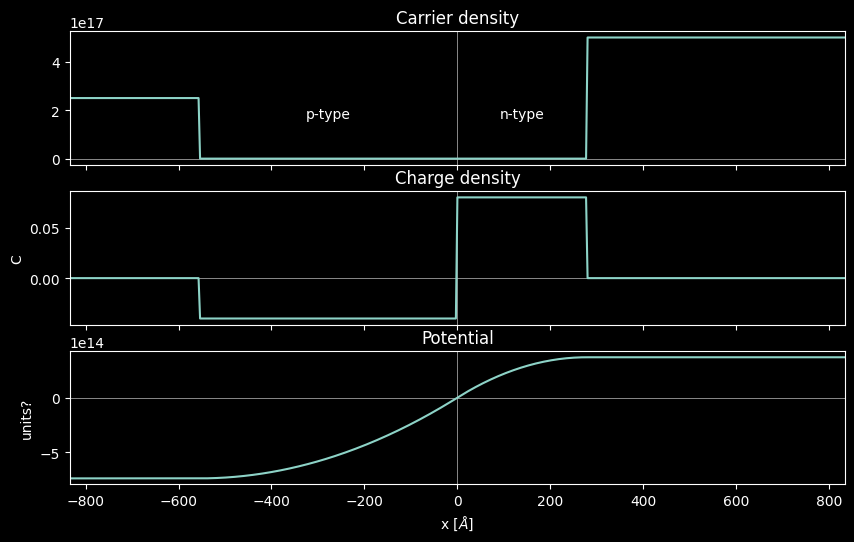

In [49]:
# calculate carrier density
def carrier_density(x):
    return np.piecewise(x, [x < -dp, ((-dp <= x) & (x < 0)), ((0 <= x) & (x <= dn)), dn < x], [Na,0,0,Nd])

# calculate charge density
def rho_doping(x):
    return np.piecewise(x, [x < -dp, ((-dp <= x) & (x < 0)), ((0 <= x) & (x <= dn)), dn < x], [0,-e*Na,e*Nd,0])

# calculate potential / Ascroft & Mermin p596-597
phi0 = 0
phi_inf = phi0 + 2*np.pi*e/epsilon*Nd*dn**2 
phi_ninf = phi0 - 2*np.pi*e/epsilon*Na*dp**2

def phi1(x):
    return phi_ninf + (2*np.pi*e*Na/epsilon) * (x + dp)**2

def phi2(x):
    return phi_inf - (2*np.pi*e*Nd/epsilon) * (x - dn)**2
    
def phi(x):
    return np.piecewise(x, [x < -dp, ((-dp <= x) & (x < 0)), ((0 <= x) & (x <= dn)), dn < x],
                        [phi_ninf, phi1, phi2, phi_inf])

# nobody reads this
a = 1.5
N = 2**9 + 1
xMax = np.maximum(dn,dp)*a
x = np.linspace(-xMax,xMax,N)

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True,figsize=(10,6),dpi=100)

# plot carrier density
plt.xlabel('x [$\AA$]')
plt.ylabel('arb. unit')
plt.xlim(-xMax,xMax)
ax1.title.set_text('Carrier density')
ax1.axhline(0, c = 'silver', linewidth = .5)
ax1.axvline(0, c = 'silver', linewidth = .5)
ax1.plot(x,carrier_density(x))
ax1.text(-dp/2,Na*2/3,'p-type',horizontalalignment='center')
ax1.text(dn/2,Na*2/3,'n-type',horizontalalignment='center')

ax2.title.set_text('Charge density')
ax2.set_ylabel('C')
ax2.axhline(0, c = 'silver', linewidth = .5)
ax2.axvline(0, c = 'silver', linewidth = .5)
ax2.plot(x,rho_doping(x))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

ax3.title.set_text('Potential')
ax3.set_ylabel('units?')
ax3.axhline(0, c = 'silver', linewidth = .5)
ax3.axvline(0, c = 'silver', linewidth = .5)
ax3.plot(x,phi(x));

In [ ]:
# numerical solution to continuity equations for charge carriers and poisson equation (silicon)

# parameters
mu_n, mu_p = 1400, 450 # cm^2/V*s
tau_n, tau_p = 2e-8, 2e-8 # s
[Dn, Dp] = [mu * kB*T/e for mu in [mu_n, mu_p]]
eps = np.finfo(float).eps
dx = (x[1] - x[0]) *1e-10 *1e2

# initial conditions
gamma = carrier_density(x)
n = 0 * gamma
p, Jn, Jp, phi, E = n, n, n, n, n

n = np.piecewise(x, [x < dn, dn <= x], [0,Nd])
p = np.piecewise(x, [x < -dp, 0 <= x], [Na,0])

# boundary conditions
gamma = -Na * (x < 0) + Nd * (x>=0)
p0 = 1
n0 = ni**2 / p0

nCenter = np.floor(N/2).astype(int)

# some handy functions
def recombination(n = n, p = p, tau_n = tau_n, tau_p = tau_p):
    return (n*p - ni**2) / (tau_n*(p+ni) + tau_p*(n+ni))

def generation(E = E, Jn = Jn, Jp = Jp):
    alpha_p0 = 2.25e7; E_pO = 3.26e6; alpha_n0 = 3.80e6; E_nO = 1.75e6;
    alpha_p = alpha_p0 * np.exp(-(E_pO / abs(E+eps)))
    alpha_n = alpha_n0 * np.exp(-(E_nO / abs(E+eps)))

    return (alpha_p*abs(Jp) + alpha_n*abs(Jn)) / e

def integral(y, dx = dx):
    return integrate.cumtrapz(y, dx = dx, initial = 0)

def derivation(x, dx = dx):
    y = np.diff(x)/dx
    return  np.append(y,y[-1])

# start with initial guess
E = -integral(-e/epsilon * (gamma + p - n))
phi = integral(-E)
phi = phi - phi[nCenter]

index = np.abs((E / np.max(abs(E)))) < 1e-2; E[index] = 0

# solving differential equations
i = 0;
while i < 1e1:
    i = i + 1;

    G = generation()
    U = recombination()
    Jp1 = integral(G - U) * e
    Jn1 = -(Jp1 - Jp1[-1])

    JpDrift = e*mu_p*p*(-E)
    JnDrift = e*mu_n*n*(-E)
    p1 = integral((JpDrift + Jp1) / (e*Dp))
    n1 = integral((JnDrift + Jn1) / (e*Dn))
    
    error = np.sum(np.abs(p1 -n1)) * dx
    rho = gamma + p - n
    E1 = -integral(-e/epsilon * rho)
    phi1 = integral(-E1)
    phi1 = phi1 - phi1[nCenter]
    
    # remove small integration errors
    index = np.abs((E1 / np.max(abs(E1)))) < 1e-2; E1[index] = 0
    
    n, p, Jn, Jp, E = n+n1, p+p1, Jn+Jn1, Jp+Jp1, E1
    
    if error < 1:
        break 

print('Lap: {}, error: {:.3e}'.format(i,error))
# display results
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True,figsize=(7,7),dpi=100)

n[n > 1e16] = 0; p[p > 1e16] = 0;
#JnDrift[np.abs(JnDrift) > 100] = 0; p[p > 1e16] = 0;

# plot carrier density
ax1.plot(x,p)
ax2.plot(x,n)
ax3.plot(x,Jp1)
ax4.plot(x,Jn1)